# **浮島発電所の発電量を予測してみる**

### **必要な関数・ライブラリ等の準備**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [5]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [8]:
def get_chunked_data(x, chunk_size):
    '''
    rnnに突っ込むためのchunk_sizeごとに区切った系列データを作る
    '''
    input_list = []
    for i in range(0, len(x) - chunk_size + 1):
        input_list.append(x[i : i + chunk_size])
    input_list = np.array(input_list)
    return input_list

In [9]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

## **データの準備**

In [10]:
# 正解データを作る
try:
    true_output = pd.read_csv('data/processed_data/output_by30.tsv', delimiter = '\t')
    true_output['datetime'] = true_output['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # train_kwhをエクセル等で開くとdatetimeが指数表示に直される可能性がある
    # その場合うまくいかないので201201010120の形になってることを確認する必要あり
    true_output = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')

    # datetimeの行をpd.Timestampのインスタンスに変更
    true_output = set_time(true_output, 'datetime')
    true_output['datetime'] = true_output['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに合計を集計
    true_output = true_output.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    true_output.to_csv('data/processed_data/output_by30.tsv', sep='\t') 
    
    true_output = pd.read_csv('data/processed_data/output_by30.tsv', delimiter = '\t')
    true_output['datetime'] = true_output['datetime'].map(lambda x : pd.to_datetime(x))
    
true_output.head()

,datetime,SOLA01,SOLA02,SOLA03
0,2012-01-01 00:00:00,0,0.0,NaN
1,2012-01-01 00:30:00,0,0.0,NaN
2,2012-01-01 01:00:00,0,0.0,NaN
3,2012-01-01 01:30:00,0,0.0,NaN
4,2012-01-01 02:00:00,0,0.0,NaN


In [11]:
# 10分単位の発電量のデータを取ってくる
output_data = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')

# datetimeの行をpd.Timestampのインスタンスに変更
output_data = set_time(output_data, 'datetime')
output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))
    
output_data.head()

,datetime,SOLA01,SOLA02,SOLA03
0,2012-01-01 00:10:00,0,0.0,NaN
1,2012-01-01 00:20:00,0,0.0,NaN
2,2012-01-01 00:30:00,0,0.0,NaN
3,2012-01-01 00:40:00,0,0.0,NaN
4,2012-01-01 00:50:00,0,0.0,NaN


In [18]:
# 予測する発電所番号を決める
target_place = 2
model_name = "model_"+str(target_place)

In [19]:
# アメダスデータの読み込み

if target_place == 1 or target_place == 2:
    # 横浜アメダスのデータを使って予測する, amd_46106
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_46106.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    amd_data.head()
elif target_place == 3:
    # 甲府アメダスのデータを使って予測する, amd_49142
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49142.tsv', delimiter = '\t')
    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    amd_data.head()
else:
    raise ValueError("invalid input target_place_num")

In [59]:
# モデル構築のためにデータを分割する

# 日射量の欠損値を一つ前の値で置換/output_data
amd_data['sl'] = amd_data['sl'].fillna(method='bfill')
amd_data['max_tp'] = amd_data['max_tp'].fillna(method='bfill')

# 学習に必要なデータ
# 2012/01/01 00:10 ~ 2015/12/30 20:00のamdデータを用いて
# 2012/01/03 03:50 ~ 2015/12/31 23:50のデータを予測する
train_x_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-01 00:10')].index[0]
train_x_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-30 20:00')].index[0]
train_y_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-03 03:50')].index[0]
train_y_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-31 23:50')].index[0]

train_amd_data = amd_data[['sl', 'max_tp']][train_x_startID:(train_x_endID+1)]
train_output_data = np.array(output_data['SOLA0'+str(target_place)][train_y_startID:(train_y_endID+1)])

# 予測に必要なデータ
# 2015/12/30 20:20 ~ 2017/3/30 20:00のamdデータを用いて
# 2016/01/01 00:00 ~ 2017/3/31 23:50のoutputデータを予測する
test_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-30 20:20')].index[0]
test_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2017-3-30 20:00')].index[0]

test_amd_data = amd_data[['sl', 'max_tp']][test_startID:(test_endID+1)]

In [63]:
# rnnに突っ込むための準備

chunk_size = 144

# rnnに突っ込むためにmin-max正規化しておく
normalized_amd = (train_amd_data - train_amd_data.min()) / (train_amd_data.max() - train_amd_data.min())
normalized_amd = np.array(normalized_amd)
normalized_test_amd = (test_amd_data - test_amd_data.min()) / (test_amd_data.max() - test_amd_data.min())
normalized_test_amd = np.array(normalized_test_amd)

#時系列データのリストにする
input_list = get_chunked_data(normalized_amd, chunk_size)

# outputがnanである学習ペアを取り除く
input_list, train_output_data = drop_nan(input_list, train_output_data)

# outputのmin_max正規化
output_min, output_max, normalized_output = normalize_array(train_output_data)

# testデータの入力を用意
test_input_list = get_chunked_data(normalized_test_amd, chunk_size)

# RNNに突っ込むためにデータを整形
X = np.array(input_list).reshape(len(input_list), chunk_size, input_list.shape[2])
Y = np.array(normalized_output).reshape(len(input_list), 1)
X_predict = np.array(test_input_list).reshape(len(test_input_list), chunk_size, test_input_list.shape[2])

### **モデルの構築**

前日の20時までの横浜のアメダスの日射量データを用いて翌日の00:00~23:50を予測する

前日の20時までのデータしか使えないので川崎近くのアメダスデータを使うのは予測として適切か疑問だったのでとりあえず1日程度ラグがありそうな(※要出典)ここのデータをつかう

(例)

8/17の00:00 ~ 23:50を予測するとき

8/17の23:50を8/15 20:10 ~ 8/16 20:00

8/17の23:40を8/15 20:00 ~ 8/16 19:50

....

8/17の00:00を8/14 20:00 ~ 8/15 20:10で予測する

参考サイト：http://www.madopro.net/entry/char_level_lm_with_simple_rnn

　　　　　　https://qiita.com/yukiB/items/f6314d2861fc8d9b739f

          https://www.tensorflow.org/install/migration
          

In [25]:
class simpleLSTM:
    def __init__(self, X, Y, epochs = 100, batch_size = 150, model_name = "test_model"):
        # 学習データと検証用データに分けておく
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.1)))
        self.X = X # 入力
        self.Y = Y # 教師
        self.X_val = X_val # 検証用
        self.Y_val = Y_val #検証用
        
        '''
        諸変数の設定
        '''
        self.input_layer_size = self.X.shape[2] #入力層の数、一つ一つのデータはslの値ひとつだけなので1
        self.hidden_layer_size = 200 # 隠れ層の数、適当
        self.output_layer_size = 1 #出力層の数、求める値は時間あたりの発電量の値1つなので1
        self.batch_size = batch_size #バッチサイズ、適当
        self.chunk_size = self.X.shape[1] # 一回の系列データの長さ
        self.learning_rate = 0.01 # 学習率 適当
        self.forget_bias = 0.9  # 忘却率
        self.epochs = epochs #エポック数
        
        # 学習データの保存
        self.model_name = str(model_name)
        
        
    def shuffle(self):
        '''
        ミニバッチかする際にランダムにシャッフル
        '''
        idx = [i for i in range(self.X.shape[0])]
        np.random.shuffle(idx)
        xs = np.array([[y for y in list(self.X[r])] for r in idx])
        ys = np.array([self.Y[r] for r in idx])
        return xs, ys
        
    def inference(self, input_ph, inistate_ph):
        '''
        グラフの構築
        '''
        
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01), name='hidden_w')
        hidden_b = tf.Variable(tf.truncated_normal([self.hidden_layer_size]), name='hidden_b')
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], stddev=0.01), name='output_w')
        output_b = tf.Variable(tf.truncated_normal([self.output_layer_size]), name='output_b')
        
        #　input_phの整型  
        in1 = tf.transpose(input_ph, [1, 0, 2]) 
        in2 = tf.reshape(in1, [-1, self.input_layer_size]) 
        in3 = tf.matmul(in2, hidden_w) + hidden_b
        in4 = tf.split(in3, self.chunk_size, 0)
          
        # BasicLSTMCellを定義
        cell = tf.contrib.rnn.BasicLSTMCell(self.hidden_layer_size, forget_bias=self.forget_bias, state_is_tuple=False)
        rnn_outputs, states = tf.contrib.rnn.static_rnn(cell, in4, initial_state=inistate_ph)
        output = tf.matmul(rnn_outputs[-1], output_w) + output_b
        results = [hidden_w, output_w, hidden_w, hidden_b]
        return output, states, results
        
    def loss(self, output_ph, actual_ph):
        '''
        お題と同じmean absolute errorを仕様
        '''
        cost = tf.reduce_mean(tf.abs(1000*(output_ph - actual_ph)))
        tf.summary.scalar('loss', cost)
        return cost
    
    def training(self, cost):
        '''
        adamを仕様beta1, beta2は元論文の推奨値を仕様
        '''
        with tf.name_scope("training") as scope:
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999).minimize(cost)
            return optimizer
    
    def train(self):
        '''
        学習
        '''
        random.seed(0)
        np.random.seed(0)
        tf.set_random_seed(0)
        n_batch = self.X.shape[0] // self.batch_size
        
        with tf.Graph().as_default():
            # 変数の用意
            input_ph = tf.placeholder('float', [None, self.chunk_size, self.input_layer_size], name='input')
            actual_ph = tf.placeholder('float', [None, self.output_layer_size], name='actual_value')
            inistate_ph = tf.placeholder('float', [None, self.hidden_layer_size * 2], name='inistate')

            prediction, state, weights = self.inference(input_ph, inistate_ph)
            cost = self.loss(prediction, actual_ph)
            optimizer = self.training(cost)

            # TensorBoardで可視化する
            summary = tf.summary.merge_all()
            # 初期化
            init = tf.global_variables_initializer()
                
            # ここから学習
            with tf.Session() as sess:
                # 学習したモデルも保存しておく
                saver = tf.train.Saver()
                summary_writer = tf.summary.FileWriter("/tmp/tensorflow_log", graph=sess.graph)
                sess.run(init)

                for epoch in range(self.epochs):
                    X_, Y_ = self.shuffle()
                    for i in range(n_batch):
                        start = i * self.batch_size
                        end = start + self.batch_size
                        inputs  = X_[start:end]
                        actuals = Y_[start:end]
                        train_dict = {
                            input_ph:      inputs,
                            actual_ph:     actuals,
                            inistate_ph:     np.zeros((self.batch_size, self.hidden_layer_size * 2)),
                        }
                    
                    sess.run(optimizer, feed_dict=train_dict)

                    if (epoch) % (self.epochs//10) == 0:
                        val_dict = {
                            input_ph:      self.X_val,
                            actual_ph:     self.Y_val,
                            inistate_ph:     np.zeros((self.X_val.shape[0], self.hidden_layer_size * 2)),
                        }
                        summary_str, train_loss = sess.run([summary, cost], feed_dict=val_dict)
                        print("train#%d, validation loss: %e" % (epoch, train_loss))
                        summary_writer.add_summary(summary_str, epoch)
                        
                    datas = sess.run(weights)
                    saver.save(sess, "./data/model/" + str(self.model_name) + ".ckpt")
                    
                datas = sess.run(weights)
                saver.save(sess, "./data/model/" + str(self.model_name) + ".ckpt")
                
    def predict(self, X_predict, model_name = "test_model"):
        '''
        予測期間に該当するデータから予測
        '''
        # 予測に使う変数の用意
        tf.reset_default_graph()
        input_ph = tf.placeholder("float", [None, self.chunk_size, self.input_layer_size], name='input')
        inistate_ph = tf.placeholder("float", [None, self.hidden_layer_size * 2], name='inistate')
        prediction, state, weights = self.inference(input_ph, inistate_ph)
        pre_dict = {
            input_ph: X_predict,
            inistate_ph: np.zeros((X_predict.shape[0], self.hidden_layer_size*2))
        }
        
        # 初期化
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            # 保存したモデルをロード
            saver = tf.train.Saver()
            saver.restore(sess, "./data/model/" + str(model_name) + ".ckpt")

            # ロードしたモデルを使って予測結果を計算
            expected_output = sess.run([prediction], feed_dict=pre_dict)


        return expected_output

In [26]:
model_01 = simpleLSTM(X, Y, epochs = 50, model_name = model_name)

In [27]:
model_01.train()

train#0, validation loss: 1.337023e+03
train#5, validation loss: 1.707487e+02
train#10, validation loss: 1.473330e+02
train#15, validation loss: 1.385548e+02
train#20, validation loss: 1.387693e+02
train#25, validation loss: 1.345960e+02
train#30, validation loss: 1.344090e+02
train#35, validation loss: 1.351688e+02
train#40, validation loss: 1.359798e+02
train#45, validation loss: 1.345029e+02


In [38]:
batch_size = 10000
n_batch = len(X) // batch_size
processed_predict = np.array([])
for i in range(n_batch+1):
    s_idx = i * batch_size
    e_idx = (i+1) * batch_size
    print(s_idx, e_idx)

0 10000
10000 20000
20000 30000
30000 40000
40000 50000
50000 60000
60000 70000
70000 80000
80000 90000
90000 100000
100000 110000
110000 120000
120000 130000
130000 140000
140000 150000
150000 160000
160000 170000
170000 180000
180000 190000
190000 200000
200000 210000


In [46]:
batch_size = 10000
n_batch = len(X[0:10000]) // batch_size
processed_predict = np.array([])
for i in range(n_batch+1):
    s_idx = i * batch_size
    e_idx = (i+1) * batch_size
    if e_idx > len(X[0:10000]):
        e_idx = len(X[0:10000])
    print("---- predict " + str(s_idx) + " ~ " + str(e_idx)+ " ----")
    predict = model_01.predict(X[s_idx:e_idx], model_name)
    predict = np.array(predict).reshape(len(predict[0]))
    tmp_predict = denormalize_array(predict, output_min, output_max)
    processed_predict = np.r_[processed_predict, tmp_predict]

---- predict 0 ~ 10000 ----
INFO:tensorflow:Restoring parameters from ./data/model/model_2.ckpt
---- predict 10000 ~ 10000 ----
INFO:tensorflow:Restoring parameters from ./data/model/model_2.ckpt


In [48]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
s_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
e_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2017/3/31 23:50')].index[0]
predict_data = pd.DataFrame({"datetime":amd_data['datetime'][s_idx:e_idx+1], "expected_output":1})
predict_data.index = np.arange(len(predict_data))
predict_data.to_csv('data/predicted_data/predict_SOLA01.tsv', sep = '\t')

In [60]:
predict_data.head()

,datetime,expected_output
0,2016-01-01 00:00:00,1
1,2016-01-02 00:10:00,1
2,2016-01-02 00:20:00,1
3,2016-01-02 00:30:00,1
4,2016-01-02 00:40:00,1


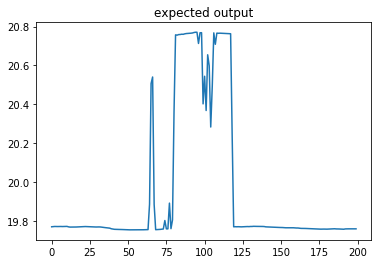

In [41]:
plt.plot(processed_predict[0:200])
plt.title("expected output")

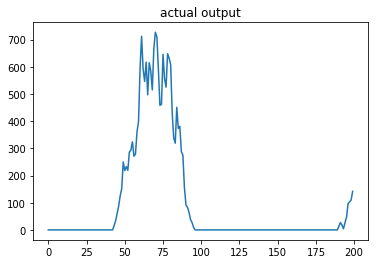

In [30]:
plt.plot(output_data['SOLA01'][0:200])
plt.title("actual output")

In [47]:
np.abs(train_output_data[0:10000] - processed_predict).mean()

251.89482965583801

In [59]:
compare = output_data[['SOLA01', 'SOLA02']]

In [60]:
# compare = compare.dropna()
dif = np.array(abs(compare['SOLA01'] - compare['SOLA02']))

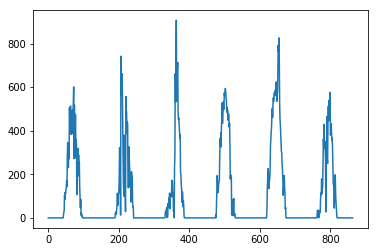

In [61]:
plt.plot(dif[0:1000])